# Trend lines of
- [ ] SST
- [ ] TCC
- [ ] LCC
- [ ] U10
- [ ] V10
- [ ] SSH
- [ ] EKE

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

In [2]:
sst_ds = xr.open_dataset('/work5/stb/ERA5/sst.nc')
tcc_ds = xr.open_dataset('/work5/stb/ERA5/tcc.nc')
mslp_ds = xr.open_dataset('/work5/stb/ERA5/mslp.nc')
u10_ds = xr.open_dataset('/work5/stb/ERA5/u10.nc')
v10_ds = xr.open_dataset('/work5/stb/ERA5/v10.nc')
mask_ds = xr.open_dataset('/work5/stb/ERA5/mask.nc')
lcc_ds = xr.open_dataset('/work/Shanice.Bailey/ERA5/lcc.nc')

## Trend lines

In [23]:
sst_dai = sst.resample(time="1D").mean()

In [24]:
sst_dai

<xarray.DataArray 'sea_surface_temperature' (time: 10408, latitude: 55,
                                             longitude: 69)> Size: 158MB
array([[[      nan,       nan,       nan, ...,       nan, 17.445765,
         18.251211],
        [      nan,       nan,       nan, ...,       nan, 18.127901,
         19.069925],
        [      nan,       nan,       nan, ...,       nan, 18.85184 ,
         19.864082],
        ...,
        [      nan,       nan,       nan, ..., 27.23551 , 27.283203,
         27.304663],
        [      nan,       nan,       nan, ..., 27.250433, 27.302359,
         27.323578],
        [      nan,       nan,       nan, ..., 27.266546, 27.328485,
         27.356821]],

       [[      nan,       nan,       nan, ...,       nan, 17.55218 ,
         18.350359],
        [      nan,       nan,       nan, ...,       nan, 18.206438,
         19.141073],
        [      nan,       nan,       nan, ...,       nan, 18.886438,
         19.901335],
...
        [      nan,       nan,       nan, ..., 28.735437, 28.702301,
         28.687708],
        [      nan,       nan,       nan, ..., 28.672644, 28.664688,
         28.660212],
        [      nan,       nan,       nan, ..., 28.621008, 28.610367,
         28.626373]],

       [[      nan,       nan,       nan, ...,       nan, 26.792318,
         26.45115 ],
        [      nan,       nan,       nan, ...,       nan, 26.918396,
         26.449072],
        [      nan,       nan,       nan, ...,       nan, 26.853745,
         26.634598],
        ...,
        [      nan,       nan,       nan, ..., 28.71073 , 28.727362,
         28.725866],
        [      nan,       nan,       nan, ..., 28.67038 , 28.654139,
         28.66097 ],
        [      nan,       nan,       nan, ..., 28.662863, 28.621948,
         28.630411]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * longitude  (longitude) float32 276B 262.0 262.2 262.5 ... 278.5 278.8 279.0
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

In [25]:
365*3

1095

In [29]:
sst_dai[1095].time

<xarray.DataArray 'time' ()> Size: 8B
array('1996-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 1996-01-01

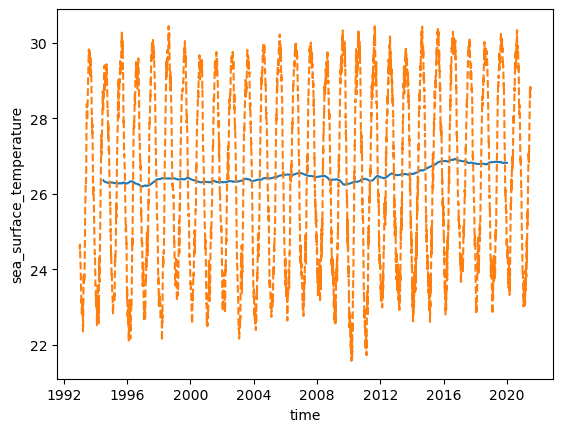

In [33]:
#rolling window is 3 yrs
sst_dai.rolling(time=1095, center=True).mean('time').mean(['latitude', 'longitude']).plot()
sst_dai.mean(['latitude', 'longitude']).plot(linestyle='dashed')

In [56]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

In [58]:
RollingOLS?

Init signature:
RollingOLS(
    endog,
    exog,
    window=None,
    *,
    min_nobs=None,
    missing='drop',
    expanding=False,
)
Docstring:     
Rolling Ordinary Least Squares

Parameters
----------
endog : array_like
    A 1-d endogenous response variable. The dependent variable.
exog : array_like
    A nobs x k array where `nobs` is the number of observations and `k`
    is the number of regressors. An intercept is not included by default
    and should be added by the user. See
    :func:`statsmodels.tools.add_constant`.
window : int
    Length of the rolling window. Must be strictly larger than the number
    of variables in the model.
min_nobs : {int, None}
    Minimum number of observations required to estimate a model when
    data are missing.  If None, the minimum depends on the number of
    regressors in the model. Must be smaller than window.
missing : str, default "drop"
    Available options are "drop", "skip" and "raise". If "drop", any
    observations with nans a

In [60]:
endog = sst_dai.mean(['latitude', 'longitude'])
exog = sm.add_constant(sst_dai.mean(['latitude', 'longitude']))
rols = RollingOLS(endog, exog, window=1095)
rres = rols.fit()
#params = rres.params.copy()
#params.index = np.arange(1, params.shape[0] + 1)
#params.head()

ValueError: unrecognized data structures: <class 'xarray.core.dataarray.DataArray'> / <class 'numpy.ndarray'>

In [7]:
#go off of spatial avg instead of sum so that we see trend line in regular ˚C, otherwise we're just adding ˚C
trend_lr = linregress(np.arange(0,249792), sst.mean(['latitude', 'longitude']))#.fillna(0.))

In [8]:
trend_lr

LinregressResult(slope=np.float64(2.430080783892529e-06), intercept=np.float64(26.160452585689725), rvalue=np.float64(0.07130824026469601), pvalue=np.float64(6.8679392087006084e-279), stderr=np.float64(6.801214731715975e-08), intercept_stderr=np.float64(0.009808510939338244))

In [9]:
trend_line_lr = (trend_lr[0]*np.arange(0,249792) + trend_lr[1])

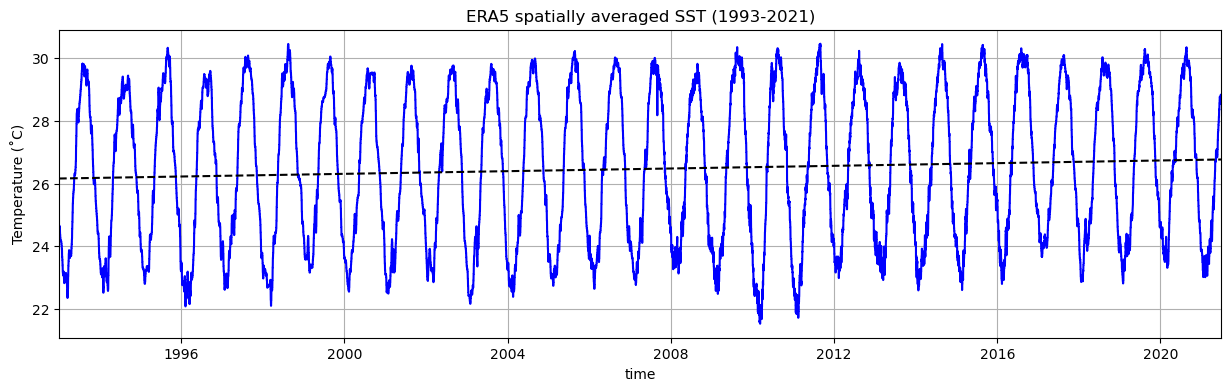

In [10]:
sst.mean(['latitude', 'longitude']).plot(figsize=(15,4), color='blue')
plt.plot(sst.time, trend_line_lr, color='k', linestyle='dashed')
plt.grid()
plt.ylabel('Temperature (˚C)')
plt.xlim(sst.time.sel(time='1993-01-01', method='nearest'), 
         sst.time.sel(time='2021-06-30', method='nearest'))
plt.title('ERA5 spatially averaged SST (1993-2021)');

In [11]:
print('Spatially averaged rate of SST increase over 1993-2021:', 
      (trend_line_lr[-1] - trend_line_lr[0]) / (2021-1993), 
      '˚C/yr')

Spatially averaged rate of SST increase over 1993-2021: 0.02167901103890354 ˚C/yr


In [62]:
sst_dai.rolling(time=1095, center=True).mean('time').mean(['latitude', 'longitude'])

<xarray.DataArray 'sea_surface_temperature' (time: 10408)> Size: 42kB
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30

In [65]:
len(trend_line_lr.resample(time="1D").mean()

AttributeError: 'numpy.ndarray' object has no attribute 'resample'

ValueError: operands could not be broadcast together with shapes (10408,) (249792,) 

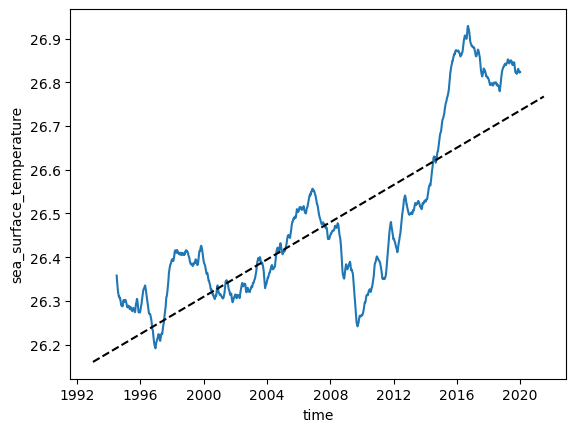

In [61]:
#rolling window is 3 yrs
sst_dai.rolling(time=1095, center=True).mean('time').mean(['latitude', 'longitude']).plot()
#sst_dai.mean(['latitude', 'longitude']).plot(linestyle='dashed')
plt.plot(sst.time, trend_line_lr, color='k', linestyle='dashed')
(sst_dai.rolling(time=1095, center=True).mean('time').mean(['latitude', 'longitude']) - 
 trend_line_lr).plot(label='diff')
pt.legend()

## Find windows of time where SST increase is highest

In [2]:
sst_ds = xr.open_dataset('/work/Shanice.Bailey/ERA5/sst.nc')
sst = sst_ds.sea_surface_temperature
sst_dai = sst.resample(time="1D").mean()

In [3]:
sst_dai

<xarray.DataArray 'sea_surface_temperature' (time: 23011, latitude: 55,
                                             longitude: 69)> Size: 349MB
array([[[       nan,        nan,        nan, ...,        nan,
         15.8969755, 16.747393 ],
        [       nan,        nan,        nan, ...,        nan,
         16.462877 , 17.520758 ],
        [       nan,        nan,        nan, ...,        nan,
         17.322313 , 18.41001  ],
        ...,
        [       nan,        nan,        nan, ..., 27.576853 ,
         27.557007 , 27.537592 ],
        [       nan,        nan,        nan, ..., 27.655237 ,
         27.612732 , 27.568567 ],
        [       nan,        nan,        nan, ..., 27.717606 ,
         27.670609 , 27.598969 ]],

       [[       nan,        nan,        nan, ...,        nan,
         15.737531 , 16.57945  ],
        [       nan,        nan,        nan, ...,        nan,
         16.298445 , 17.363672 ],
        [       nan,        nan,        nan, ...,        nan,
         17.159254 , 18.268106 ],
...
        [       nan,        nan,        nan, ..., 27.891531 ,
         27.858652 , 27.832123 ],
        [       nan,        nan,        nan, ..., 27.87882  ,
         27.863367 , 27.81991  ],
        [       nan,        nan,        nan, ..., 27.881577 ,
         27.898489 , 27.89034  ]],

       [[       nan,        nan,        nan, ...,        nan,
         18.109812 , 18.431112 ],
        [       nan,        nan,        nan, ...,        nan,
         18.860205 , 19.05941  ],
        [       nan,        nan,        nan, ...,        nan,
         19.253448 , 19.760345 ],
        ...,
        [       nan,        nan,        nan, ..., 27.839197 ,
         27.835083 , 27.823156 ],
        [       nan,        nan,        nan, ..., 27.827993 ,
         27.822046 , 27.801239 ],
        [       nan,        nan,        nan, ..., 27.871668 ,
         27.828873 , 27.8057   ]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 220B 31.0 30.75 30.5 30.25 ... 18.0 17.75 17.5
  * longitude  (longitude) float32 276B 262.0 262.2 262.5 ... 278.5 278.8 279.0
  * time       (time) datetime64[ns] 184kB 1959-01-01 1959-01-02 ... 2021-12-31

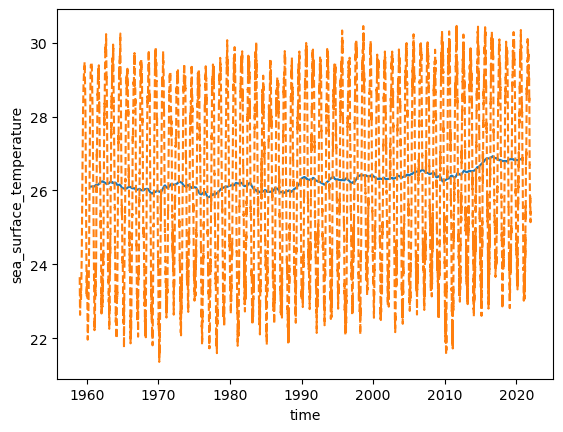

In [4]:
#rolling window is 3 yrs
sst_dai.rolling(time=1095, center=True).mean('time').mean(['latitude', 'longitude']).plot()
sst_dai.mean(['latitude', 'longitude']).plot(linestyle='dashed')

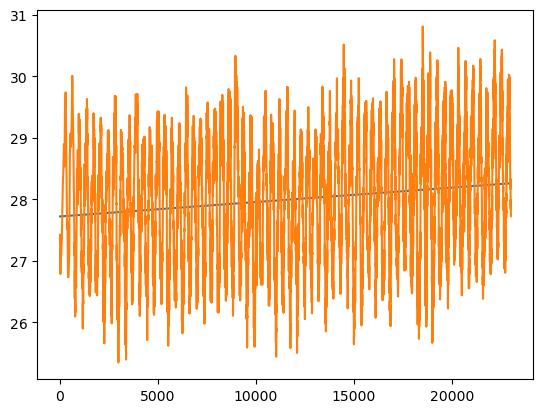

In [5]:
#get a sense of magnitude of trend slope at a single grid pt
z = np.polyfit(np.arange(1,23012), sst_dai[:,50, 50], 1)
p = np.poly1d(z)
plt.plot(np.arange(1,23012), p(np.arange(1,23012)))
plt.plot(np.arange(1,23012), sst_dai[:,50,50])

In [10]:
aw = sst_dai.polyfit('time', deg=1, skipna = True)

In [14]:
aw.polyfit_coefficients.mean(['latitude', 'longitude'])

<xarray.DataArray 'polyfit_coefficients' (degree: 2)> Size: 16B
array([4.08867959e-19, 2.60086574e+01])
Coordinates:
  * degree   (degree) int64 16B 1 0

In [6]:
from scipy.stats import linregress
#go off of spatial avg instead of sum so that we see trend line in regular ˚C, otherwise we're just adding ˚C
trend_lr = linregress(np.arange(0,23011), sst_dai.mean(['latitude', 'longitude']))#.fillna(0.))

In [7]:
trend_lr

LinregressResult(slope=np.float64(3.532619153902803e-05), intercept=np.float64(25.86671784200266), rvalue=np.float64(0.09500639245819835), pvalue=np.float64(2.74394486262921e-47), stderr=np.float64(2.4402043826289965e-06), intercept_stderr=np.float64(0.032418051853159616))

In [15]:
trend_line_lr = (trend_lr[0]*np.arange(0,23011) + trend_lr[1])

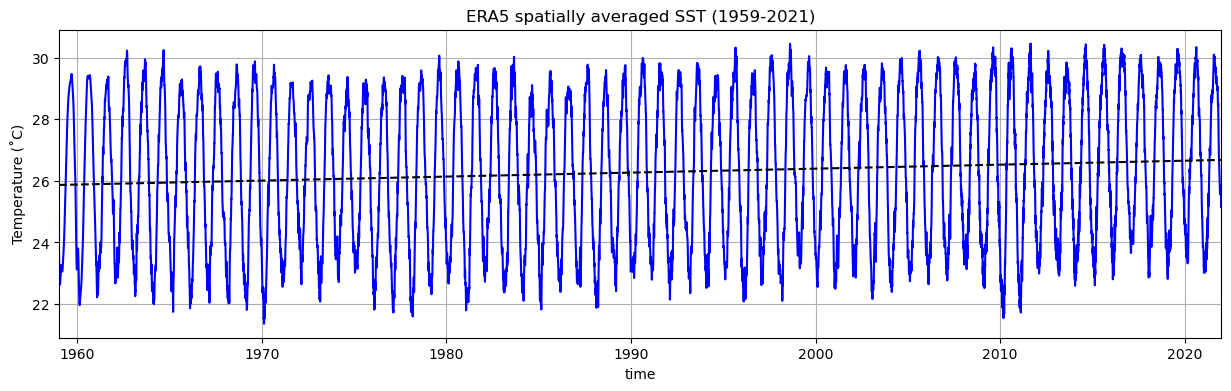

In [16]:
sst_dai.mean(['latitude', 'longitude']).plot(figsize=(15,4), color='blue')
plt.plot(sst_dai.time, trend_line_lr, color='k', linestyle='dashed')
plt.grid()
plt.ylabel('Temperature (˚C)')
plt.xlim(sst.time.sel(time='1959-01-01', method='nearest'), 
         sst.time.sel(time='2021-12-31', method='nearest'))
plt.title('ERA5 spatially averaged SST (1959-2021)');

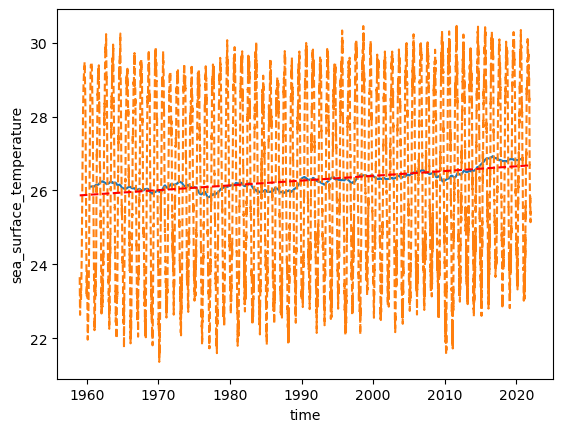

In [17]:
#rolling window is 3 yrs
sst_dai.rolling(time=1095, center=True).mean('time').mean(['latitude', 'longitude']).plot()
sst_dai.mean(['latitude', 'longitude']).plot(linestyle='dashed')
plt.plot(sst_dai.time, trend_line_lr, color='r', linestyle='dashed')

In [28]:
#two ways to find the windows of time where sst increase was fastest/highest
#Method A: Take the difference between the rolling average curve and trend line
sst_roll = sst_dai.rolling(time=1095, center=True).mean('time').mean(['latitude', 'longitude'])
roll_minus_trend = sst_roll - trend_line_lr
#Method B: take derivate of the rolling average curve
dt = (sst_roll.time.diff('time') / 1e9).astype('f4')
dydx = sst_roll.diff('time') / dt

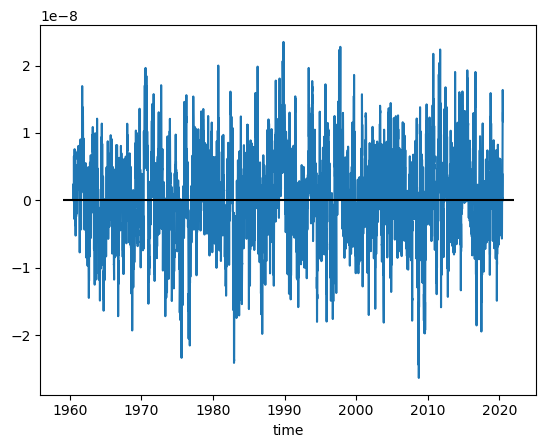

In [42]:
(dydx).plot()
plt.hlines(y=0, xmin=dydx.time[0], xmax=dydx.time[-1], color='k');

In [38]:
d2ydx2 = dydx.diff('time') / (dt**2)

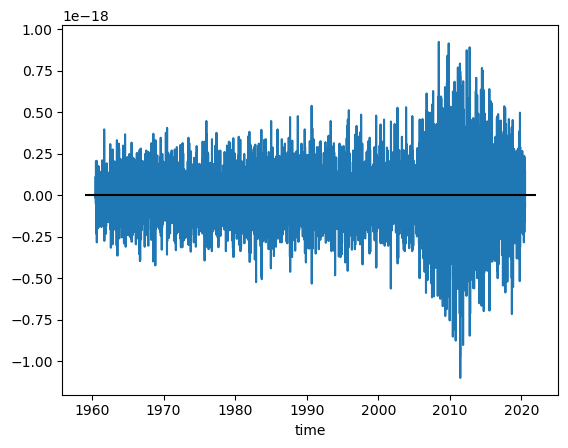

In [45]:
d2ydx2.plot()
plt.hlines(y=0, xmin=d2ydx2.time[0], xmax=d2ydx2.time[-1], color='k');

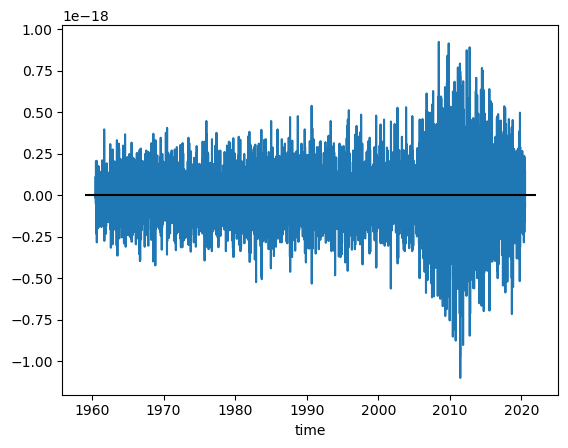

In [51]:
d2ydx2.plot()
plt.hlines(y=0, xmin=d2ydx2.time[0], xmax=d2ydx2.time[-1], color='k')
#plt.xlim(d2ydx2.time.sel(time='2005', method='nearest'), d2ydx2.time.isel(time=-1));

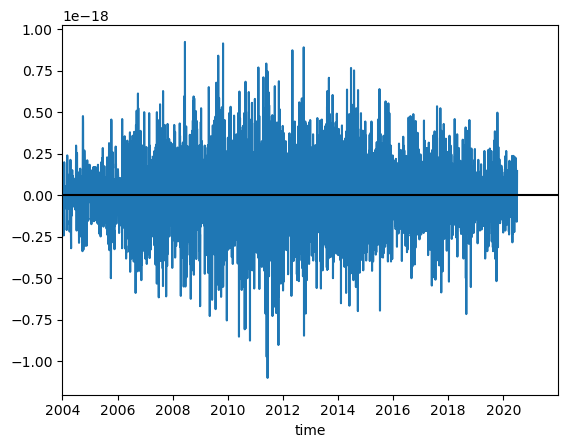

In [52]:
d2ydx2.plot()
plt.hlines(y=0, xmin=d2ydx2.time[0], xmax=d2ydx2.time[-1], color='k')
plt.xlim(d2ydx2.time.sel(time='2004', method='nearest'), d2ydx2.time.isel(time=-1));

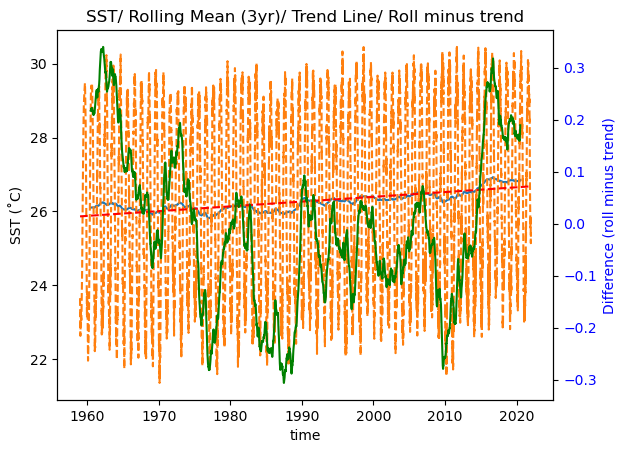

In [39]:
fig, ax0 = plt.subplots()
sst_dai.rolling(time=1095, center=True).mean('time').mean(['latitude', 'longitude']).plot(ax=ax0)
sst_dai.mean(['latitude', 'longitude']).plot(linestyle='dashed', ax=ax0)
ax0.plot(sst_dai.time, trend_line_lr, color='r', linestyle='dashed')
ax0.tick_params(axis='y', labelcolor='k')
ax0.set_ylabel('SST (˚C)')
ax1 = ax0.twinx()  # Create a twin Axes sharing the x-axis
roll_minus_trend.plot(color='green', ax=ax1)
ax1.set_ylabel('Difference (roll minus trend)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.title('SST/ Rolling Mean (3yr)/ Trend Line/ Roll minus trend');